In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import scanpy as sc
import numpy as np
import pandas as pd
import cv2
import math
from pathlib import Path, PurePath
from scipy.spatial import distance
from scipy.ndimage import gaussian_filter
from typing import Union, Dict, Optional, Tuple, BinaryIO
import json

from PIL import Image

In [2]:
plt.rc('font', size = 15)

In [5]:
tissue_dir = '/home/seohyepark/_Nature/CRC_16_human_only'
metafile = None

In [6]:
adata1 = sc.read_visium(tissue_dir) 

/home/seohyepark/yes/envs/CellDART/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
#adata1 = sc.read_visium(tissue_dir) 
### alternatively ###
# adata1 = sc.read_10x_mtx(tissue_dir) 

adata1.var_names_make_unique() 
# sc.pp.normalize_total(adata1, inplace=True) 
# sc.pp.log1p(adata1)
# sc.pp.highly_variable_genes(adata1, flavor="seurat", n_top_genes=17189)

In [8]:
import pandas as pd
import scanpy as sc

score_df = pd.read_csv(tissue_dir + '/barcode_score.csv', index_col='barcode')
adata1.obs['score'] = adata1.obs_names.map(score_df['score'])

In [9]:
adata1.obs

,in_tissue,array_row,array_col,score
AAACAACGAATAGTTC-1,1,0,16,24.0
AAACAAGTATCTCCCA-1,1,50,102,0.0
AAACAATCTACTAGCA-1,1,3,43,4.0
AAACACCAATAACTGC-1,1,59,19,1205.0
AAACAGAGCGACTCCT-1,1,14,94,0.0
...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,94.0
TTGTTTCATTAGTCTA-1,1,60,30,67.0
TTGTTTCCATACAACT-1,1,45,27,0.0
TTGTTTGTATTACACG-1,1,73,41,33.0


In [10]:
adata1.obs['Total RNA Reads'] = adata1.X.sum(axis=1).A1

In [11]:
adata1.obs['Bacterial Reads from PathSeq'] = adata1.obs['score']

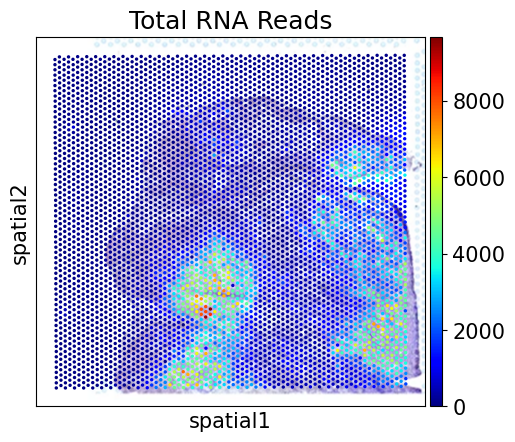

In [13]:
sc.pl.spatial(adata1, img_key="hires", color=['Total RNA Reads'], alpha=1, cmap='jet')

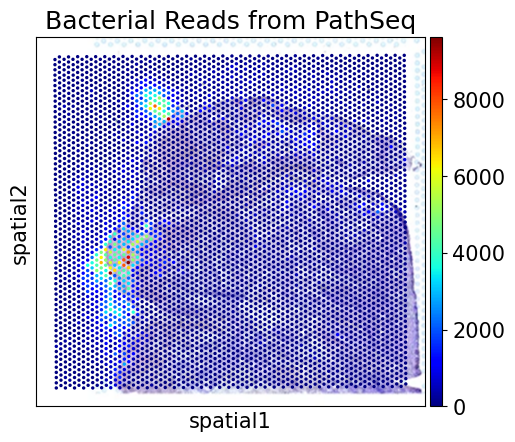

In [14]:
sc.pl.spatial(adata1, img_key="hires", color=['Bacterial Reads from PathSeq'], alpha=1, cmap='jet')

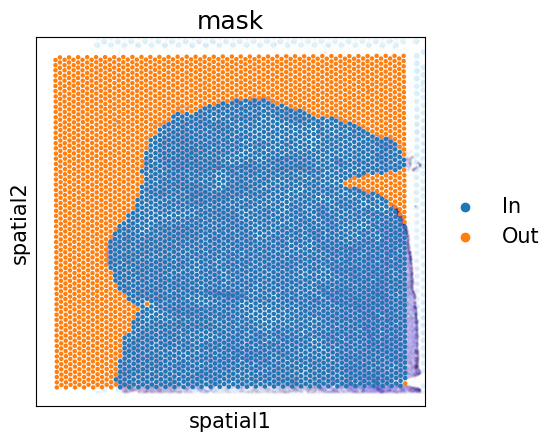

In [15]:
import pandas as pd
import scanpy as sc

# CRC_mask.csv 파일 읽기
mask_df = pd.read_csv('./CRC_16_human_16S_rRNA/outs/CRC_mask.csv', index_col=0)

# adata1.obs에 mask 정보 추가하기
adata1.obs['mask'] = mask_df['mask_in']
adata1.obs['mask'] = adata1.obs['mask'].fillna('Out')

# 'in_tissue' 열에서 'In'은 1로, 'Out'은 0으로 매핑합니다.
adata1.obs['in_tissue'] = adata1.obs['mask'].apply(lambda x: 1 if x == 'In' else 0)

# Spatial plot 그리기, 'In'과 'Out'에 따라 색상을 다르게 지정
sc.pl.spatial(adata1, color='mask', spot_size=20)


In [16]:
adata=adata1

In [17]:
# 'in_tissue' 열에서 'In'은 1로, 'Out'은 0으로 매핑합니다.
adata.obs['in_tissue'] = adata.obs['mask'].apply(lambda x: 1 if x == 'In' else 0)
adata.obs['in_tissue'] = adata.obs['in_tissue'].astype(int)

# 결과를 확인합니다.
print(adata.obs.head())


                    in_tissue  array_row  array_col   score  Total RNA Reads  \
AAACAACGAATAGTTC-1          0          0         16    24.0            340.0   
AAACAAGTATCTCCCA-1          1         50        102     0.0            616.0   
AAACAATCTACTAGCA-1          1          3         43     4.0           3672.0   
AAACACCAATAACTGC-1          0         59         19  1205.0            112.0   
AAACAGAGCGACTCCT-1          1         14         94     0.0            580.0   

                    Bacterial Reads from PathSeq mask  
AAACAACGAATAGTTC-1                          24.0  Out  
AAACAAGTATCTCCCA-1                           0.0   In  
AAACAATCTACTAGCA-1                           4.0   In  
AAACACCAATAACTGC-1                        1205.0  Out  
AAACAGAGCGACTCCT-1                           0.0   In  


In [18]:
tissue_positions_df = pd.read_csv('/home/seohyepark/_Nature/CRC_16_human_only/spatial/tissue_positions_list.csv')

In [20]:
from scipy.spatial import distance
import numpy as np

# array_row와 array_col을 기반으로 모든 샘플 간의 거리를 계산합니다.
coords = adata.obs[['array_row', 'array_col']].values
dist_matrix = distance.cdist(coords, coords, 'euclidean')

# in_tissue의 총 합을 계산합니다.
total_in_tissue = adata.obs['in_tissue'].sum()

# 조건을 만족하는 최소 이웃의 수를 찾기 위한 변수를 초기화합니다.
min_neighbors = 1
condition_met = False

# 조건을 만족할 때까지 이웃의 수를 증가시키면서 반복합니다.
for n_neighbors in range(1, len(adata.obs) + 1):
    # 각 샘플에 대해 n_neighbors 만큼의 가장 가까운 이웃을 찾습니다.
    nearest_neighbors_indices = np.argsort(dist_matrix, axis=1)[:, 1:n_neighbors+1]

    # 새로운 플래그를 계산합니다.
    new_flag = []
    for idx, neighbors in enumerate(nearest_neighbors_indices):
        # 이웃들의 in_tissue 값 검사
        neighbor_in_tissue = adata.obs.iloc[neighbors]['in_tissue'].values
        # 이웃 중 하나라도 in_tissue가 1이면, 해당 샘플의 플래그를 true로 설정
        new_flag.append(np.any(neighbor_in_tissue == 1))

    # new_flag의 총 합을 계산합니다.
    total_new_flag = np.sum(new_flag)

    # 조건이 충족되는지 검사합니다.
    if total_new_flag >= 1.2 * total_in_tissue:
        min_neighbors = n_neighbors
        condition_met = True
        break

# 결과를 출력합니다.
if condition_met:
    print(f"최소 이웃의 수: {min_neighbors}, 이 때 new_flag의 총 합은 in_tissue의 1.2 배 이상입니다.")
    # 새로운 플래그를 adata.obs에 추가합니다.
    adata.obs['new_flag'] = new_flag
else:
    print("어떤 이웃의 수에서도 new_flag의 총 합이 in_tissue의 1.2 배를 초과하지 않습니다.")


최소 이웃의 수: 69, 이 때 new_flag의 총 합은 in_tissue의 1.2 배 이상입니다.


In [22]:
from scipy.spatial import distance
import numpy as np

# array_row와 array_col을 기반으로 모든 샘플 간의 거리를 계산합니다.
min_neighbors = 69
coords = adata.obs[['array_row', 'array_col']].values
dist_matrix = distance.cdist(coords, coords, 'euclidean')

# 각 샘플에 대해 가장 가까운 3개의 이웃을 찾습니다 (자기 자신을 제외).
# argsort를 사용하여 각 행마다 거리가 가장 짧은 이웃의 인덱스를 얻습니다.
nearest_neighbors_indices = np.argsort(dist_matrix, axis=1)[:, 1:(min_neighbors+1)]

# in_tissue 값을 기반으로 새로운 플래그를 생성합니다.
# 이 플래그는 주어진 샘플이 이웃 중 하나 이상이 in_tissue가 1인 경우 true로 설정됩니다.
new_flag = []
for idx, neighbors in enumerate(nearest_neighbors_indices):
    # 이웃들의 in_tissue 값 검사
    neighbor_in_tissue = adata.obs.iloc[neighbors]['in_tissue'].values
    # 이웃 중 하나라도 in_tissue가 1이면, 해당 샘플의 플래그를 true로 설정
    new_flag.append(np.any(neighbor_in_tissue == 1))

# 새로운 플래그를 adata.obs에 추가
adata.obs['new_flag'] = new_flag

# 결과 확인
print(adata.obs[['array_row', 'array_col', 'in_tissue', 'new_flag']].head())

# 선택적으로, spatial plot 생성
#sc.pl.spatial(filtered_adata, color='new_flag')


                    array_row  array_col  in_tissue  new_flag
AAACAACGAATAGTTC-1          0         16          0     False
AAACAAGTATCTCCCA-1         50        102          1      True
AAACAATCTACTAGCA-1          3         43          1      True
AAACACCAATAACTGC-1         59         19          0     False
AAACAGAGCGACTCCT-1         14         94          1      True


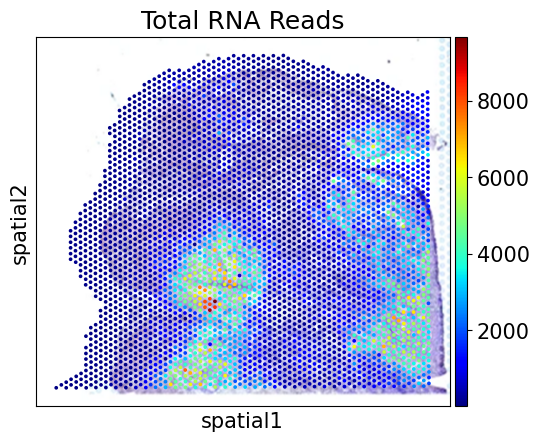

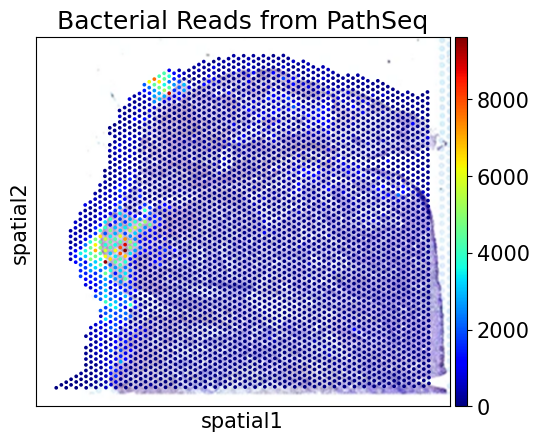

In [23]:
# 선택적으로, spatial plot 생성
# sc.pl.spatial(adata, color='new_flag')

filtered_adata = adata[adata.obs['new_flag'] == True]

#sc.pl.spatial(filtered_adata, color = 'n_counts', cmap='jet')
sc.pl.spatial(filtered_adata, img_key="hires", color=['Total RNA Reads'], alpha=1, cmap='jet')

#sc.pl.spatial(filtered_adata, color = '16S_rRNA', cmap='jet')
sc.pl.spatial(filtered_adata, img_key="hires", color=['Bacterial Reads from PathSeq'], alpha=1, cmap='jet')
